# Coronavirus Tweet Classification

Welcome to the Coronavirus Tweet Classification where today, we will be analysing 40,000 tweets about the Covid-19 pandemic and predict whether they are positive, negative or neutral. Using these predictions, we can figure out how people are dealing with the pandemic and we can take a step further in figuring out how to make the world a calmer place.

In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv


In [33]:
train = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin1')

## Feature engineering

Firstly we will gather the data. As seen below, we have acquired train and test sets, both consisting of UserName, ScreenName, Location, TweetAt, OriginalTweet and Sentiment columns.

In [34]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [35]:
test

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


The 'OriginalTweet' feature from will be used as X and the 'Sentiment' as the target. Then, we encode the target (y) feature with a label encoder in order for it to be able to be inputted to the classifier.

In [36]:
le = LabelEncoder()
X_train = train['OriginalTweet']
y_train = le.fit_transform(train['Sentiment'])

X_test = test['OriginalTweet']
y_test = le.transform(test['Sentiment'])

Now we create three models: Bag of Words, TFIDF and Tokenizer in order to be able to convert the text data (X) into a usable matrix of numbers. All models are created in order to test them out and see which one is the best for use.

In [37]:
BoW = CountVectorizer()
tfidf = TfidfTransformer()
tok = Tokenizer(num_words=50, split=" ")

At last, we create different transformations of the Bag of Word, TFIDF and Tokenizer methods. All three methods are types of NLP (Natural Language Processing) approaches that work in different ways to help AIs get better at reading and understanding text.

In [40]:
X_tr_bow = BoW.fit_transform(X_train)
X_te_bow = BoW.transform(X_test)

X_tr_tfidf = tfidf.fit_transform(X_tr_bow)
X_te_tfidf = tfidf.transform(X_te_bow)

tok.fit_on_texts(X_train)
tok_train = tok.texts_to_sequences(X_train)
X_tr_tok = sequence.pad_sequences(tok_train, maxlen=11, dtype='float32')

tok_test = tok.texts_to_sequences(X_test)
X_te_tok = sequence.pad_sequences(tok_test, maxlen=11, dtype='float32')

# Data visualisation

Subsequently, we will now visualise the data that has been engineered. This is useful as it can help us understand the trend of which our data follows.

Below is a word cloud that shows which words are the most common. 'https' and 'co' are the most common due to people linking their websites in tweets. Following are the words 'COVID' and a misspelled version of 'coronavirus'. After that are words such as 'grocery' and 'supermarket', which isn't surprising due to people's concerns about not being able to go out and buy things.

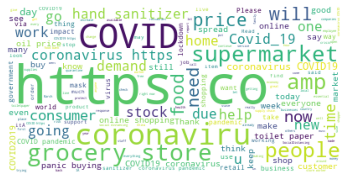

In [38]:
wordcloud = WordCloud(background_color='white').generate(" ".join(X))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The final piece of visualisation is two bar charts which plot out how many tweets happened each day of the month and every month of the year. The month of March is when the most tweets happened, presumably because that was when lockdown started.

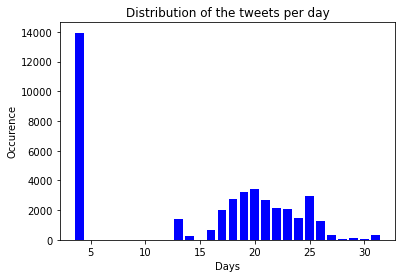

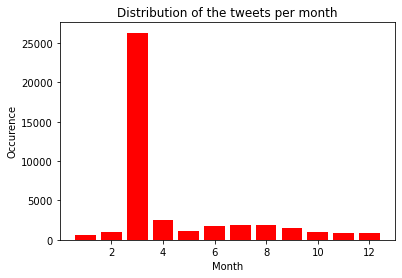

In [39]:
month = pd.to_datetime(train['TweetAt']).dt.month
day = pd.to_datetime(train['TweetAt']).dt.day

count = Counter(day)
plt.bar(count.keys(), count.values(), color='blue')
plt.xlabel('Days')
plt.ylabel('Occurence')
plt.title('Distribution of the tweets per day')
plt.show()

count = Counter(month)
plt.bar(count.keys(), count.values(), color='red')
plt.xlabel('Month')
plt.ylabel('Occurence')
plt.title('Distribution of the tweets per month')
plt.show()

Now, at the climax of our notebook, we shall create three SGD classifiers which each use the NLP approaches to create predictions as to whether a tweet is positive, negative or neutral.

In [42]:
bow_clf = SGDClassifier(eta0=0.01, learning_rate='optimal', penalty='l1', max_iter=100)
bow_clf.fit(X_tr_bow, y_train)
bow_score = bow_clf.score(X_te_bow, y_test)
print('Bag of Words score: ' + str(bow_score))

tfidf_clf = SGDClassifier(eta0=0.0001, loss='modified_huber', penalty='l1', learning_rate='optimal')
tfidf_clf.fit(X_tr_tfidf, y_train)
tfidf_score = tfidf_clf.score(X_te_tfidf, y_test)
print('TFIDF score:        ' + str(tfidf_score))

tok_clf = SGDClassifier()
tok_clf.fit(X_tr_tok, y_train)
tok_score = tok_clf.score(X_te_tok, y_test)
print('Tokenizer score:    ' + str(tok_score))

Bag of Words score: 0.6000526592943655
TFIDF score:        0.590047393364929
Tokenizer score:    0.18167456556082148


As seen above, the SGD classifier which has had its data engineered with a Bag of Words method has the highest accuracy, with a score of 60%. Meanwhile, the TFIDF score is closely behind with 59% and the Tokenizer is far back with 18%.

In [43]:
pred = bow_clf.predict(X_te_bow)
output = pd.DataFrame({'Real': y_test, 'Prediction': pred})
output.to_csv('submission.csv', index=False)

## Thank you for reading my notebook. 
## If you enjoyed it and found it helpful, please upvote it as it would help me make more of these.